In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Movie recommender") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/09 21:39:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/09 21:39:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Caricamento file utenti

In [2]:
users = spark.read.json("ml-1m/users.json")
users.createOrReplaceTempView("users")
users.count()

6040

In [3]:
users.show()

+---+------+----------+------+-------+
|age|gender|occupation|userid|zipcode|
+---+------+----------+------+-------+
|  1|     F|        10|     1|  48067|
| 56|     M|        16|     2|  70072|
| 25|     M|        15|     3|  55117|
| 45|     M|         7|     4|  02460|
| 25|     M|        20|     5|  55455|
| 50|     F|         9|     6|  55117|
| 35|     M|         1|     7|  06810|
| 25|     M|        12|     8|  11413|
| 25|     M|        17|     9|  61614|
| 35|     F|         1|    10|  95370|
| 25|     F|         1|    11|  04093|
| 25|     M|        12|    12|  32793|
| 45|     M|         1|    13|  93304|
| 35|     M|         0|    14|  60126|
| 25|     M|         7|    15|  22903|
| 35|     F|         0|    16|  20670|
| 50|     M|         1|    17|  95350|
| 18|     F|         3|    18|  95825|
|  1|     M|        10|    19|  48073|
| 25|     M|        14|    20|  55113|
+---+------+----------+------+-------+
only showing top 20 rows



Caricamento file film

In [4]:
movies = spark.read.json("ml-1m/movies.json")
movies.createOrReplaceTempView("movies")
movies.count()

3883

In [5]:
movies.show()

+--------------------+-------+--------------------+
|              genres|movieid|               title|
+--------------------+-------+--------------------+
|Animation|Childre...|      1|    Toy Story (1995)|
|Adventure|Childre...|      2|      Jumanji (1995)|
|      Comedy|Romance|      3|Grumpier Old Men ...|
|        Comedy|Drama|      4|Waiting to Exhale...|
|              Comedy|      5|Father of the Bri...|
|Action|Crime|Thri...|      6|         Heat (1995)|
|      Comedy|Romance|      7|      Sabrina (1995)|
|Adventure|Children's|      8| Tom and Huck (1995)|
|              Action|      9| Sudden Death (1995)|
|Action|Adventure|...|     10|    GoldenEye (1995)|
|Comedy|Drama|Romance|     11|American Presiden...|
|       Comedy|Horror|     12|Dracula: Dead and...|
|Animation|Children's|     13|        Balto (1995)|
|               Drama|     14|        Nixon (1995)|
|Action|Adventure|...|     15|Cutthroat Island ...|
|      Drama|Thriller|     16|       Casino (1995)|
|       Dram

Creazione dizionario: dato un id di un film posso in questo modo recuperare il titolo

In [6]:
movies = movies.na.fill(0) # un id non è specificato, quindi verrà sovrascritto a 0
moviesMap = dict(movies.rdd.map(lambda movie: (int(movie[1]), movie[2])).collect())

Caricamento file voti

In [8]:
ratings = spark.read.json("ml-1m/ratings.json")
ratings.createOrReplaceTempView("ratings")
ratings.count()

1000209

In [9]:
ratings.show()

+-------+------+---------+------+
|movieid|rating|timestamp|userid|
+-------+------+---------+------+
|   1193|     5|978300760|     1|
|    661|     3|978302109|     1|
|    914|     3|978301968|     1|
|   3408|     4|978300275|     1|
|   2355|     5|978824291|     1|
|   1197|     3|978302268|     1|
|   1287|     5|978302039|     1|
|   2804|     5|978300719|     1|
|    594|     4|978302268|     1|
|    919|     4|978301368|     1|
|    595|     5|978824268|     1|
|    938|     4|978301752|     1|
|   2398|     4|978302281|     1|
|   2918|     4|978302124|     1|
|   1035|     5|978301753|     1|
|   2791|     4|978302188|     1|
|   2687|     3|978824268|     1|
|   2018|     4|978301777|     1|
|   3105|     5|978301713|     1|
|   2797|     4|978302039|     1|
+-------+------+---------+------+
only showing top 20 rows



Ripartizione utenti per fascia di età

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

utentiDF = spark.sql("select age, count(1) as count from users group by age order by age")

utentiDF.show()

+---+-----+
|age|count|
+---+-----+
|  1|  222|
| 18| 1103|
| 25| 2096|
| 35| 1193|
| 45|  550|
| 50|  496|
| 56|  380|
+---+-----+



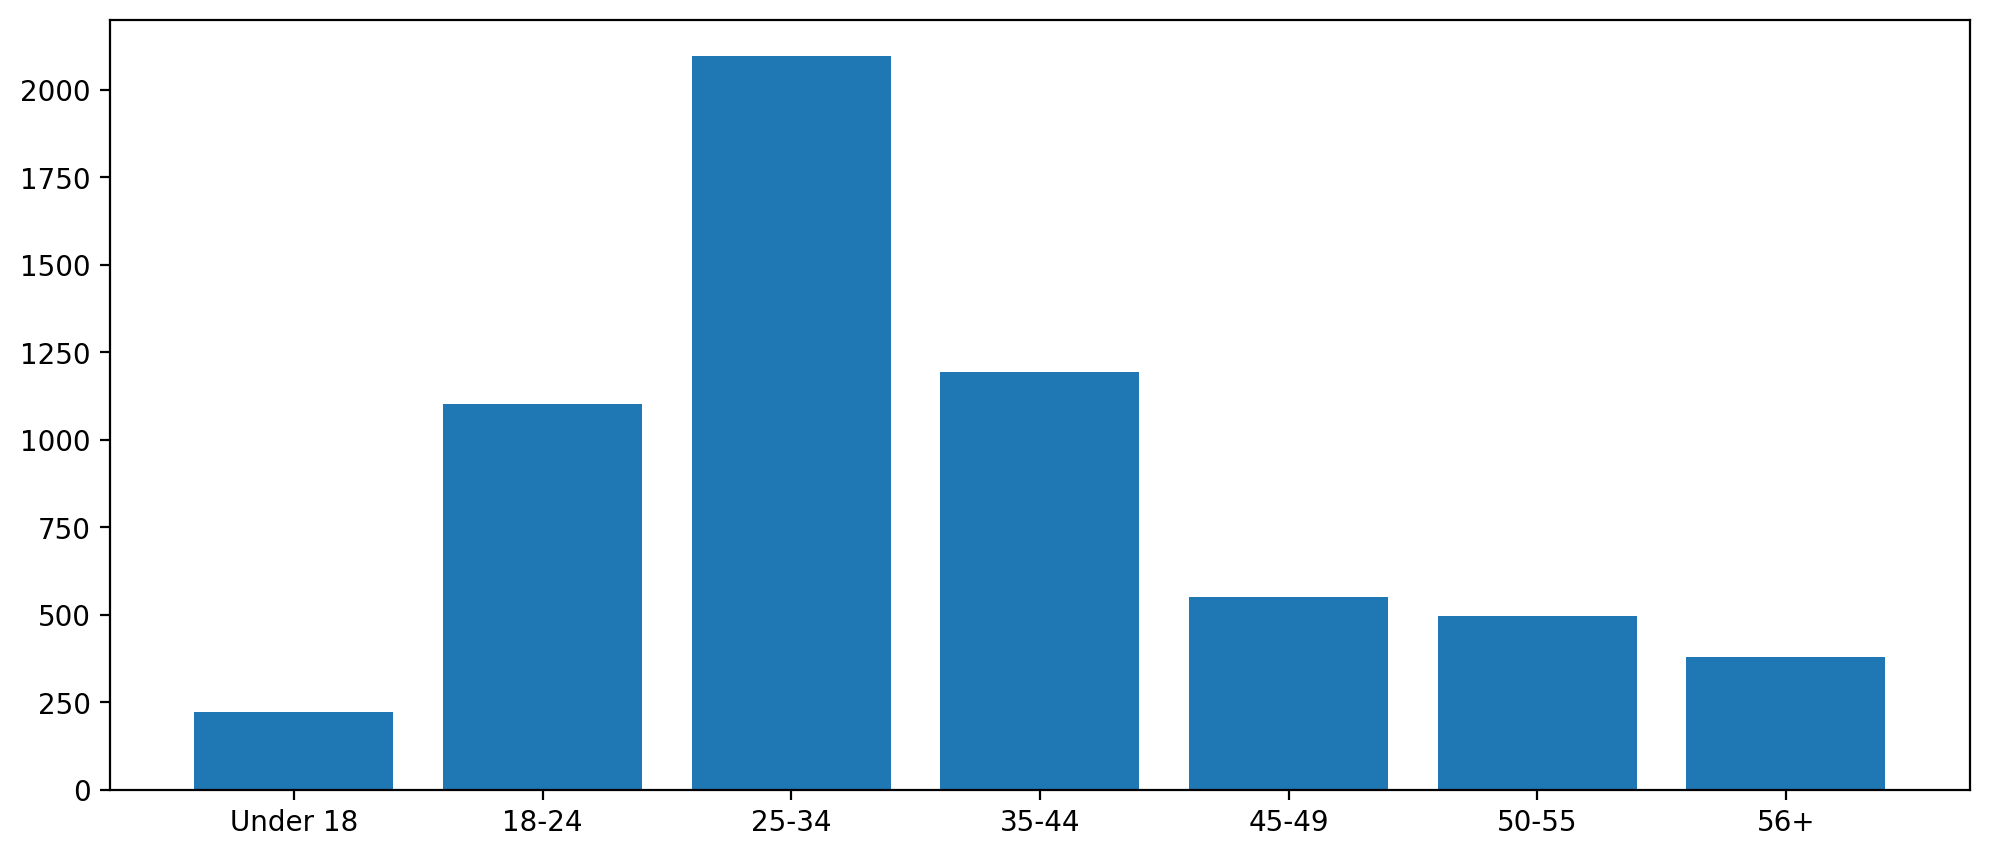

In [11]:
fig, ax = plt.subplots(figsize=(12,5))

fascieEta = range(7);
counts = utentiDF.select("count").rdd.map(lambda r: r[0]).collect();

plt.bar(fascieEta, counts);
plt.xticks([0,1,2,3,4,5,6],("Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56+"))
plt.show()

Migliori film con almeno 2000 voti

In [12]:
miglioriDF = spark.sql('''select count(*) as count, r.movieid, m.title, avg(rating) as avg from ratings r
                            join movies m on m.movieid = r.movieid
                            group by r.movieid, m.title 
                            having count(*) >= 2000
                            order by avg desc
                        ''')
miglioriDF.show(truncate=False)

+-----+-------+-----------------------------------------------------+------------------+
|count|movieid|title                                                |avg               |
+-----+-------+-----------------------------------------------------+------------------+
|2227 |318    |Shawshank Redemption, The (1994)                     |4.554557700942973 |
|2223 |858    |Godfather, The (1972)                                |4.524966261808367 |
|2304 |527    |Schindler's List (1993)                              |4.510416666666667 |
|2514 |1198   |Raiders of the Lost Ark (1981)                       |4.477724741447892 |
|2991 |260    |Star Wars: Episode IV - A New Hope (1977)            |4.453694416583082 |
|2459 |2762   |Sixth Sense, The (1999)                              |4.406262708418057 |
|2578 |593    |Silence of the Lambs, The (1991)                     |4.3518231186966645|
|2653 |2028   |Saving Private Ryan (1998)                           |4.337353938937053 |
|3428 |2858   |Americ

Media voti per un film (Dirty Dancing)

In [13]:
import pyspark.sql.functions as F

#Utilizzando dataframe API
ddancing = ratings.filter(ratings.movieid==1088)\
           .groupBy("movieid") \
           .agg(F.avg("rating"), F.count("rating"))
 
ddancing.show()

+-------+------------------+-------------+
|movieid|       avg(rating)|count(rating)|
+-------+------------------+-------------+
|   1088|3.3114992721979624|          687|
+-------+------------------+-------------+



In [14]:
ddancing.collect()[0][1]

3.3114992721979624

In [15]:
#Utilizzando SQL API
spark.sql('''select count(*) as count, r.movieid, avg(rating) as avg from ratings r
             where r.movieid = 1088
             group by r.movieid''').show()

+-----+-------+------------------+
|count|movieid|               avg|
+-----+-------+------------------+
|  687|   1088|3.3114992721979624|
+-----+-------+------------------+



Distribuzione del voto

In [16]:
spark.sql('''select count(*), r.movieid, m.gender, avg(rating) as avg from ratings r
             join users m on m.userid = r.userid
             where r.movieid = 1088
             group by r.movieid, m.gender''').show()


+--------+-------+------+-----------------+
|count(1)|movieid|gender|              avg|
+--------+-------+------+-----------------+
|     291|   1088|     F|3.790378006872852|
|     396|   1088|     M| 2.95959595959596|
+--------+-------+------+-----------------+



Come trovare i film con più differenze tra gusto maschile vs femminile?

In [17]:
spark.sql('''select count(*) c, f.std, f.movieid, title, M, F from (
                    select stddev(avg) std, last(avg) M, first(avg) F, i.movieid from (
                        select count(*) cc, r.movieid, m.gender, avg(rating) as avg from ratings r
                            join users m on m.userid = r.userid
                            group by r.movieid, m.gender
                            order by m.gender
                            ) i
                        group by i.movieid
                        having std != 'NaN'
                    ) f
                join ratings rr on rr.movieid = f.movieid
                join movies mm on mm.movieid = f.movieid
                group by f.movieid, f.std, mm.title, f.m, f.F
                having c >= 500
                order by std desc
                limit 30''').show(truncate=False)

+----+-------------------+-------+--------------------------------------+------------------+------------------+
|c   |std                |movieid|title                                 |M                 |F                 |
+----+-------------------+-------+--------------------------------------+------------------+------------------+
|687 |0.5874516193175334 |1088   |Dirty Dancing (1987)                  |2.95959595959596  |3.790378006872852 |
|822 |0.5136074654412537 |1201   |Good, The Bad and The Ugly, The (1966)|4.2213001383125865|3.494949494949495 |
|660 |0.45156428402833654|231    |Dumb & Dumber (1994)                  |3.336594911937378 |2.697986577181208 |
|548 |0.4327390285366185 |1261   |Evil Dead II (Dead By Dawn) (1987)    |3.909282700421941 |3.2972972972972974|
|817 |0.430079187011439  |1380   |Grease (1978)                         |3.3670411985018727|3.9752650176678443|
|967 |0.40559756437511346|3552   |Caddyshack (1980)                     |3.969736842105263 |3.3961352657

In [18]:
moviesMap[1036]

'Die Hard (1988)'

### Raccomandare film: ALS

https://spark.apache.org/docs/2.4.3/mllib-collaborative-filtering.html

Aggiungiamo al set di training dei voti personali

In [19]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

myratings = spark.sparkContext.parallelize([Rating(0,1036,5.0)])
moviesMap[1036]

'Die Hard (1988)'

In [20]:
ratingsRDD = ratings.rdd.map(lambda r: Rating(int(r[3]), int(r[0]), float(r[1])))

Uniamo i ratings degli utenti ai voti personali

In [21]:
training = ratingsRDD.union(myratings).cache()

Lanciamo il training del modello ALS

In [22]:
model = ALS.train(training, 50, 5, 0.1)

25/04/09 21:41:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/09 21:41:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Top 10 raccomandazioni

In [23]:
model.recommendProducts(0,10)

[Rating(user=0, product=853, rating=5.013305043597364),
 Rating(user=0, product=572, rating=4.935722975601389),
 Rating(user=0, product=1036, rating=4.7844493766380785),
 Rating(user=0, product=1198, rating=4.63347753479467),
 Rating(user=0, product=589, rating=4.623662592030423),
 Rating(user=0, product=1240, rating=4.504772963409326),
 Rating(user=0, product=1420, rating=4.496169280339615),
 Rating(user=0, product=260, rating=4.465268086425163),
 Rating(user=0, product=2494, rating=4.439592503197068),
 Rating(user=0, product=2905, rating=4.4355211913555195)]

In [24]:
list(map(lambda r: moviesMap[r.product], model.recommendProducts(0,10)))

['Dingo (1992)',
 'Foreign Student (1994)',
 'Die Hard (1988)',
 'Raiders of the Lost Ark (1981)',
 'Terminator 2: Judgment Day (1991)',
 'Terminator, The (1984)',
 'Message to Love: The Isle of Wight Festival (1996)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Last Days, The (1998)',
 'Sanjuro (1962)']